### Deep Ensamble MDN Toy Example ###

"We use the same network architecture: 1-hidden layer neural network with ReLU nonlinearity (Nair and Hinton, 2010), containing 50 hidden units for smaller datasets and 100 hidden units for the larger protein and Year Prediction MSD datasets"

"We trained for 40 epochs; we refer to (Herna ́ndez-Lobato and Adams, 2015) for further details about the datasets and the experimental protocol. We used 5 networks in our ensemble. Our results are shown in Table 1, along with the PBP and MC-dropout results reported in their respective papers"

"On some datasets, we observe that our method is slightly worse in terms of RMSE. We believe that this might be caused due to the het- eroscedastic regression training criterion, which optimises for NLL instead of MSE as discussed in the toy example in Figure 3."

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import os
import copy
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from aml_dl.mdn.model.tf_ensemble_mdn_model import EnsambleMDN

from aml_dl.gp.simple_gp import GaussianProcess, kernel

from IPython import display
import time

## Configs

In [5]:
EXP_NAME = 'exp_ensemble'

check_point_dir   = os.environ['AML_DATA'] + '/aml_dl/mdn/tf_check_points/exp_ensemble/'
summary_dir = os.environ['AML_DATA'] + '/aml_dl/mdn/summaries/exp_ensemble/'

if not os.path.exists(check_point_dir):
    os.makedirs(check_point_dir)

if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

adam_params = {
    'type': 'adam',
    'params': {'learning_rate' : 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'use_locking': False}
}

network_params = {
    'n_ensembles': 5,
    'dim_input': 1, 
    'dim_output': 1,
    'n_hidden': [20,20,10],#[20,20,10],
    'k_mixtures': 1,
    'write_summary': False,
    'load_saved_model': False,
    'model_dir': check_point_dir + '/inv/',
    'model_name':'ensemble_model_inv_10_kernels.ckpt',
    'optimiser': adam_params,
    'summary_dir':summary_dir+'/inv/',
    'device': '/cpu:0',
}

In [6]:
tf.set_random_seed(42)
sess = tf.InteractiveSession()

In [7]:
ensamble_mdn = EnsambleMDN(network_params,sess)

In [8]:
noise_level = 0.1#0.00000001;
width = 0.5
scale = 30


gp = GaussianProcess(noise_level, width, scale, kernel)

In [9]:
ensamble_mdn._init_model()

## Prepare data

In [10]:
def fun_h(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return np.cos(2*t - 1/2)/2 + np.cos(t) + 1 + noise

def fun_poly(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return -0.01*(t ** 3) + np.square(t)*0.01 + noise

# *
def fun_s(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return (t-8) ** 3 - 5 * (t - 8)

def fun_c(t, noise_gain=0.0):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
        
    return t * np.cos(t) + noise

def fun_g(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    noise = noise_gain*np.random.randn(d1, d2)
    return np.divide(np.power(np.multiply((np.sin(t) - np.sin(2*t)/2 + np.sin(3*t)/3. - 
                                           np.sin(4*t)/4. + 4),t),2),(t+1)) + noise

def sawtoothxy(x,y):
    t, r = cart2pol(x,y) # change to polar coordinates
    h = fun_h(t)
    g = fun_g(r)
    f = np.multiply(g,h)
    return f

func_y = fun_h

In [11]:
num_data_points = 2000 # 1000
x_values = np.linspace(0, 12, num_data_points)
y_values = func_y(x_values, 0.0)

In [12]:
num_data_points = 2000 # 2000
gdx_values = np.linspace(0, 12, num_data_points)
gdy_values = func_y(gdx_values, 0.0)

In [13]:




def test_and_plot(i, loss):
    
    x_test = gdx_values#np.linspace(0, 12, num_data_points)
    y_test = gdy_values #fun_h(x_test, 0.0)
    
    out_mus = ensamble_mdn.run_op(sess, 'mus', np.expand_dims(x_test,axis=1))
    out_sigma = ensamble_mdn.run_op(sess, 'sigmas', np.expand_dims(x_test,axis=1))
    out_pis = ensamble_mdn.run_op(sess, 'pis', np.expand_dims(x_test,axis=1))
    
    mean_out, var_out = ensamble_mdn.forward(sess, np.expand_dims(x_test,axis=1))
    
    stddev = 3.0
    fig2 = plt.figure(1,figsize=(15,15))
    fig2.clf()
    ax = fig2.add_subplot(411)

    ypl = [float(mu-stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]
    yph = [float(mu+stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]

    ax.plot(x_test, y_test, color='r')

    ax.fill_between(x_test.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.9)
    ax.plot(x_test, mean_out, color='b', linewidth=2.5)

#     colours = np.random.rand((network_params['n_ensembles'],3))#['g','c','k','m','y','']

    for k in range(network_params['n_ensembles']):
        ax.plot(x_test, np.reshape(out_mus[k],(-1,)), color=(np.random.rand(), np.random.rand(), np.random.rand()),linewidth=0.5)

    ax.scatter(x_train, y_train)

    x_test = gdx_values#np.linspace(0, 12, num_data_points)
    y_test = gdy_values #fun_h(x_test, 0.0)
#     plt.show()
    
    plt.title('Iteration %d'%(i,))
    
    ax2 = fig2.add_subplot(412)
    mloss = np.mean(loss,axis=0)
    ax2.plot(mloss[:None], 'r-')
    
    ax3 = fig2.add_subplot(413)
    ax3.plot(x_test, np.sqrt(var_out), color='g')
    
    
    return fig2, mloss
    

In [14]:
# x_train = x_values[350:650,None]
# y_train = y_values[350:650,None]
# x_train = x_values[600:900,None]
# y_train = y_values[600:900,None]

# x_train = x_values[753:1054,None]
# y_train = y_values[753:1054,None]

In [15]:
# x_train = np.vstack([x_values[15:20,None],x_values[45:50,None],x_values[75:80,None]])
# y_train = np.vstack([y_values[15:20,None],y_values[45:50,None],y_values[75:80,None]])

In [16]:
x_train = np.vstack([x_values[200:400,None],x_values[750:1000,None],x_values[1250:1450,None]])
y_train = np.vstack([y_values[200:400,None],y_values[750:1000,None],y_values[1250:1450,None]])

In [17]:
for idx in range(x_train.shape[0]):
    gp.update(x_train[idx,:], y_train[idx,:])

In [18]:
pred, cov, logp = gp.predict3(x_values)
std = np.sqrt(np.diagonal(cov))

In [19]:
sample_posterior = gp.sample_multivariate(pred, cov, len(pred), 5)

/Users/ermanoarruda/Projects/ros_ws/aml/aml_dl/src/aml_dl/gp/simple_gp.py:130: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu.ravel(), cov,n_samples).T


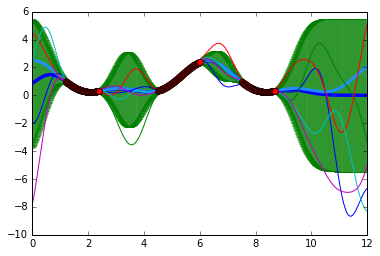

In [20]:
plt.errorbar(x_values, pred, yerr=std, fmt='b-', ecolor='g', elinewidth=0.25, linewidth=3.5)
plt.plot(x_values, y_values, 'dodgerblue', linewidth=3.0)
plt.plot(x_values, sample_posterior)
plt.plot(gp.x, gp.y, 'ro')

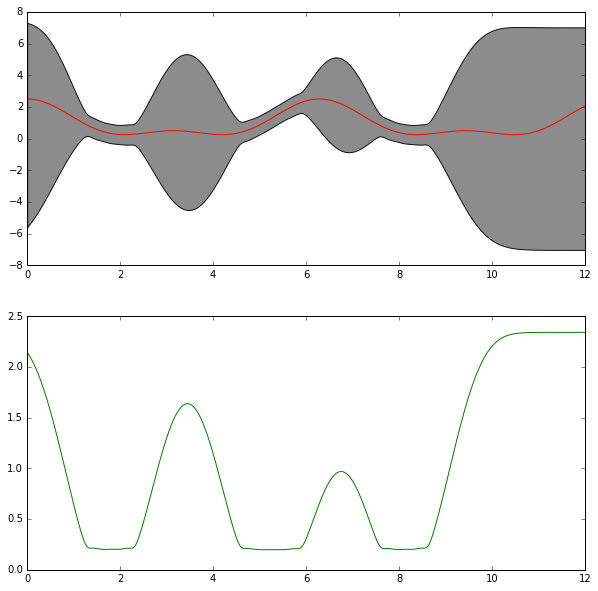

In [21]:
stddev = 3.0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ypl = [float(mu-stddev*np.sqrt(sig)) for mu,sig in zip(pred,std)]
yph = [float(mu+stddev*np.sqrt(sig)) for mu,sig in zip(pred,std)]

ax.plot(x_values, y_values, color='r')

ax.fill_between(x_values.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.9)

ax2 = fig.add_subplot(212)

ax2.plot(x_values, np.sqrt(std), color='g')

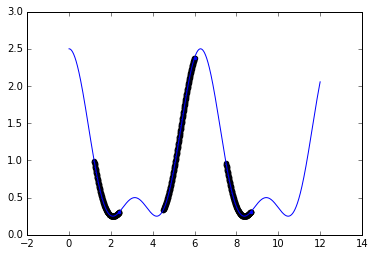

In [22]:
plt.figure()
plt.scatter(x_train,y_train)
plt.plot(gdx_values,gdy_values)
plt.show()

In [ ]:
iterations = 40

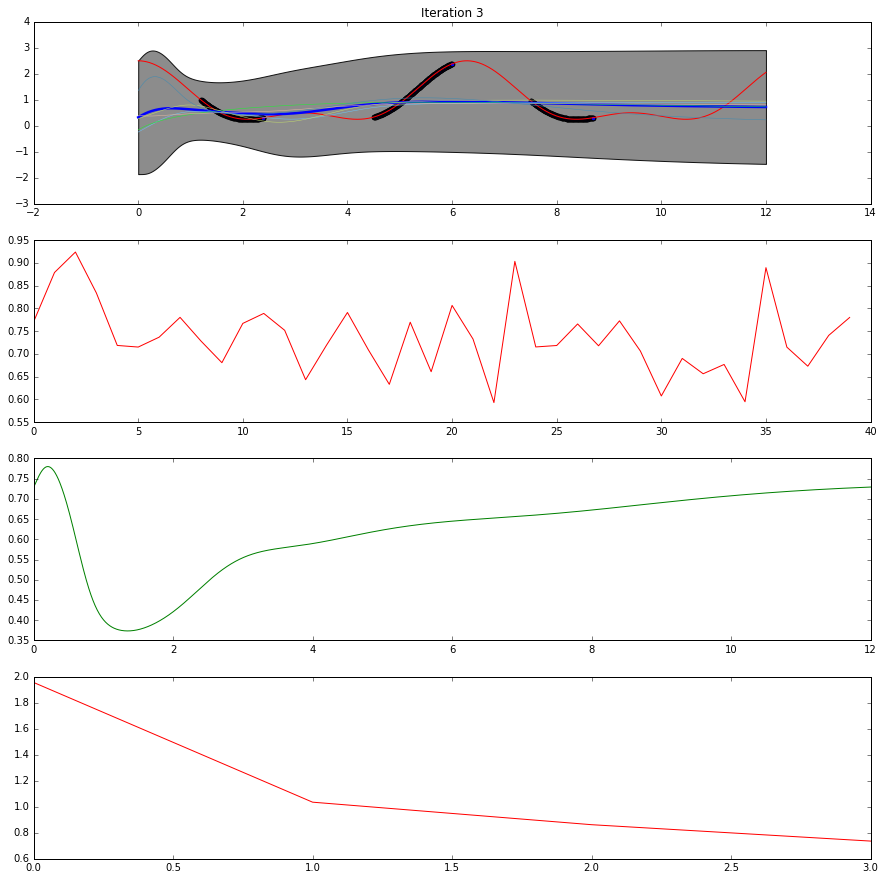

In [ ]:

mean_loss = []
for i in range(100):
    loss = ensamble_mdn.train(x_train, y_train, sess, iterations)

    fig, mloss = test_and_plot(i, loss)
    mean_loss.append(np.mean(mloss))
    ax2 = fig.add_subplot(414)
    ax2.plot(mean_loss, 'r-')
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    
#     ax = fig2.add_subplot(212)
#     ax.plot(np.arange(100, iterations,1), loss[0, 100:], 'r-')

In [ ]:
#plot loss curves
plt.figure(figsize=(15,15))
plot_no=network_params['n_ensembles']*100+11
for k in range(network_params['n_ensembles']):
    plt.subplot(plot_no)
    plt.plot(np.arange(100, iterations,1), loss[k, 100:], 'r-')
    plot_no += 1
plt.show()

## Test

In [ ]:
x_test = gdx_values#np.linspace(0, 12, num_data_points)
y_test = gdy_values #fun_h(x_test, 0.0)

In [ ]:
out_mus = ensamble_mdn.run_op(sess, 'mus', np.expand_dims(x_test,axis=1))
out_sigma = ensamble_mdn.run_op(sess, 'sigmas', np.expand_dims(x_test,axis=1))
out_pis = ensamble_mdn.run_op(sess, 'pis', np.expand_dims(x_test,axis=1))

In [ ]:
# out_mus = np.reshape(out_mus,(-1,1))
# out_sigma = np.reshape(out_sigma,(-1,1))
# out_pis = np.reshape(out_pis,(-1,1))

In [ ]:
# print np.reshape(out_mus[0],(-1,1))
# print out_sigma.shape
# print out_pis.shape

In [ ]:
y_test.shape

In [ ]:
mean_out, var_out = ensamble_mdn.forward(sess, np.expand_dims(x_test,axis=1))

In [ ]:
stddev = 3.0

fig2 = plt.figure(2, figsize=(10,10))
ax = fig2.add_subplot(111)

ypl = [float(mu-stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]
yph = [float(mu+stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]

ax.plot(x_test, y_test, color='r')

ax.fill_between(x_test.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.9)
ax.plot(x_test, mean_out, color='b', linewidth=2.5)

colours = ['g','c','k','m','y']

for k in range(network_params['n_ensembles']):
    ax.plot(x_test, np.reshape(out_mus[k],(-1,)), color=(np.random.rand(),np.random.rand(),np.random.rand()),linewidth=0.5)

plt.scatter(x_train,y_values)


plt.show()